## Introduction to ICESat-2 Surface Velocity Calculations

This notebook is meant to introduce the processing flow for a simple along-track velocity calculation using repeat cysles of ICESat-2 elevation profiles. The notebook covers:
1. Setting up the IS2_velocity library
2. Loading elevation data from an hdf5 file using the built-in reader function.
3. Smoothing and differentiating the elevation profile.
4. Correlating the differentiated profile to calculate surface velocities.

In [1]:
# Import the basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Library Setup

In order to run the IS2_velocity scripts as a python library, you must first:
1. Download or clone the repository at https://github.com/ICESAT-2HackWeek/IS2_velocity.git
2. Install the dependencies including numpy, scipy, h5py, astropy, icepyx, and the ICESat-2 pointCollection library.
3. Go the the home directory in our repository and run ‘python setup.py install’.

If you successfully run the setup.py script, you should be able to run the cell below.

In [3]:
# As an example, import a function from the ICESat-2 surface velocity library
from IS2_velocity.correlation_processing import calculate_velocities
help(calculate_velocities)

Help on function calculate_velocities in module IS2_velocity.correlation_processing:

calculate_velocities(rgt, x_atc, h_li_raw, h_li_diff, lats, lons, segment_ids, times, beams, cycle1, cycle2, product, segment_length, search_width, along_track_step, max_percent_nans, dx, saving=False, write_out_path='.', prepend='', spatial_extent=None, map_data_root=None)
    :param x_atc:
    :param h_li_diff:
    :param lats:
    :param lons:
    :param segment_ids:
    :param beams:
    :param cycle1:
    :param cycle2:
    :param segment_length:
    :param search_width:
    :param along_track_step:
    :param max_percent_nans:
    :param dx:
    :return:



# Velocity calculation: Control correlations

In [4]:
# Import funcitons for the velocity calculation; Correlate all the beams from one set of repeat ground tracks, rgt = 0848
from IS2_velocity.correlation_processing import calculate_velocities

### Select rgt for now
rgt = '0848'

### Control the correlation step:
segment_length = 2000 # meters, how wide is the window we are correlating in each step
search_width = 1000 # meters, how far in front of and behind the window to check for correlation
along_track_step = 100 # meters; how much to jump between each consecutivevelocity determination
max_percent_nans = 10 # Maximum % of segment length that can be nans and still do the correlation step

### Which product
product = 'ATL06'
if product == 'ATL06':
    dx = 20

### Select filter type and required arguments; Currently only this running mean is supported
filter_type = 'running_average'
running_avg_window = 100 # meters

# Velocity calculation: Load Data / Import dictionaries

In [5]:
from IS2_velocity.readers import load_data_by_rgt
# atl06_to_dict is within the function load_data_by_rgt

# path to data, relative to folder /notebooks
data_dir = '../data/'
rgt = '0848'

# Load data; This step loads raw data, interpolates to constant spacing, filters if requested, and 
# differentiates
filter_type = 'running_average'
running_avg_window = 100

x_atc, lats, lons, h_li_raw, h_li_raw_NoNans, h_li, h_li_diff, times, min_seg_ids, \
segment_ids, cycles_this_rgt, x_ps, y_ps = \
    load_data_by_rgt(rgt = rgt, path_to_data = data_dir, product = 'ATL06', \
                     filter_type = filter_type, running_avg_window = running_avg_window, \
                     format = 'hdf5')


Cycles available: 03,04


## Visualize one of the beams

<IPython.core.display.Javascript object>


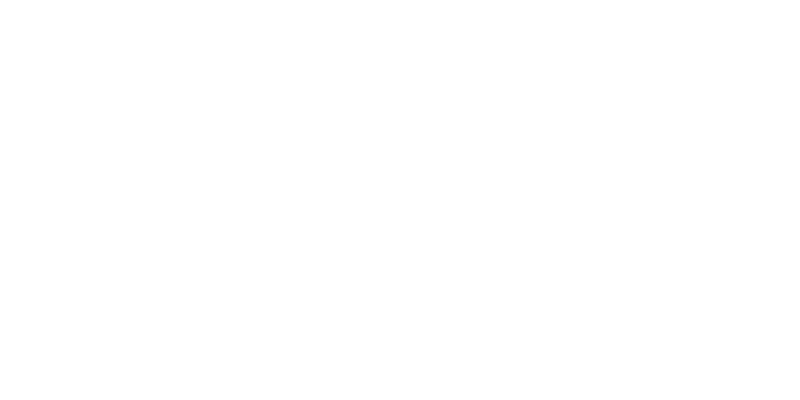

In [6]:
# Plot the landice elevation along the pass.

cycle1='03'
cycle2='04'
beam='gt1l'

plt.figure(figsize=(8,4))

plt.plot(x_atc[cycle1][beam]/1000.,h_li[cycle1][beam],c='indianred')
plt.plot(x_atc[cycle2][beam]/1000.,h_li[cycle2][beam],c='steelblue')
plt.ylabel('Elevation (m)')
plt.xlabel('Along-Track Distance (km)')

plt.tight_layout()

# Velocity calculation: Calculate velocity between cycles 03 and 04

In [7]:
from IS2_velocity.correlation_processing import calculate_velocities

# Calculate velocity between cycles 3 and 4
cycle1 = '03'
cycle2 = '04'
beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

saving = True
write_out_path = '.'
write_out_prefix = ''

spatial_extent = np.array([-65, -86, -55, -81])
map_data_root = '/Users/grace/Dropbox/Cornell/projects/003/FIS_data/'

velocities, correlations, lags, midpoints_x_atc, midpoints_xy, midpoints_lons, midpoints_lats = \
    calculate_velocities(rgt, x_atc, h_li_raw, h_li_diff, lats, lons, segment_ids, times, beams, cycle1, cycle2, \
             product, segment_length, search_width, along_track_step, max_percent_nans, dx, saving = True, \
             write_out_path = write_out_path, prepend = write_out_prefix,spatial_extent = spatial_extent, \
             map_data_root = map_data_root)



# Velocity calculation: Visualize result for one beam 

<IPython.core.display.Javascript object>


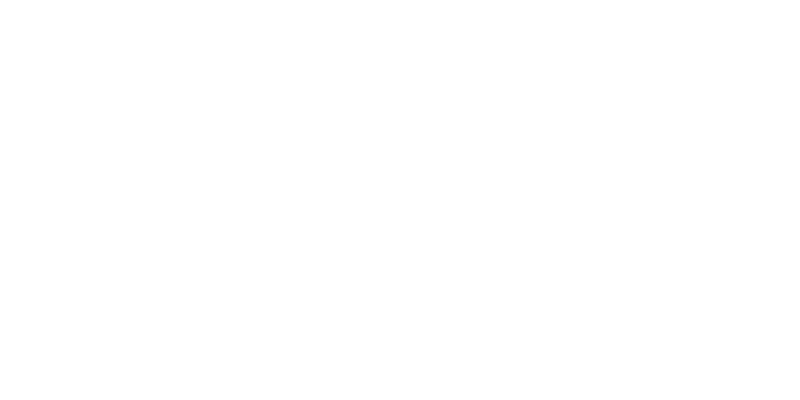

In [8]:


from matplotlib.gridspec import GridSpec

beam = 'gt1l'
x1 = x_atc['03'][beam]
x2 = x_atc['04'][beam]
h1 = h_li['03'][beam]
h2 = h_li['04'][beam]
dh1 = h_li_diff['03'][beam]
dh2 = h_li_diff['04'][beam]
vel_xs = midpoints_x_atc[rgt][beam]
velocs = velocities[rgt][beam]

plt.figure(figsize=(8,4))
gs = GridSpec(2,2)

# Plot the elevation profiles again
plt.subplot(gs[0,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,h1,'.',c='indianred')
plt.plot(x2/1000.-29000,h2,'.',c='steelblue',ms=3)
plt.ylabel('Elevation (m)')
plt.title('ATL06',fontweight='bold')
plt.xlim(80,580)

# Plot the slopes again
plt.subplot(gs[1,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,dh1,'.',c='indianred')
plt.plot(x2/1000.-29000,dh2,'.',c='steelblue',ms=3)
plt.ylim(-.05,.05)
plt.ylabel('Surface Slope (m/m)')
plt.xlim(80,580)

# Plot the calculated velocities along track
ax5 = plt.subplot(gs[0,1])
plt.plot(vel_xs/1000.-29000,velocs,'.',c='k',label='ATL06')
plt.ylabel('Velocity (m/yr)')
plt.xlabel('Along-Track Distance (km)')
plt.xlim(80,580)
plt.ylim(-500,1500)

plt.tight_layout()

<IPython.core.display.Javascript object>


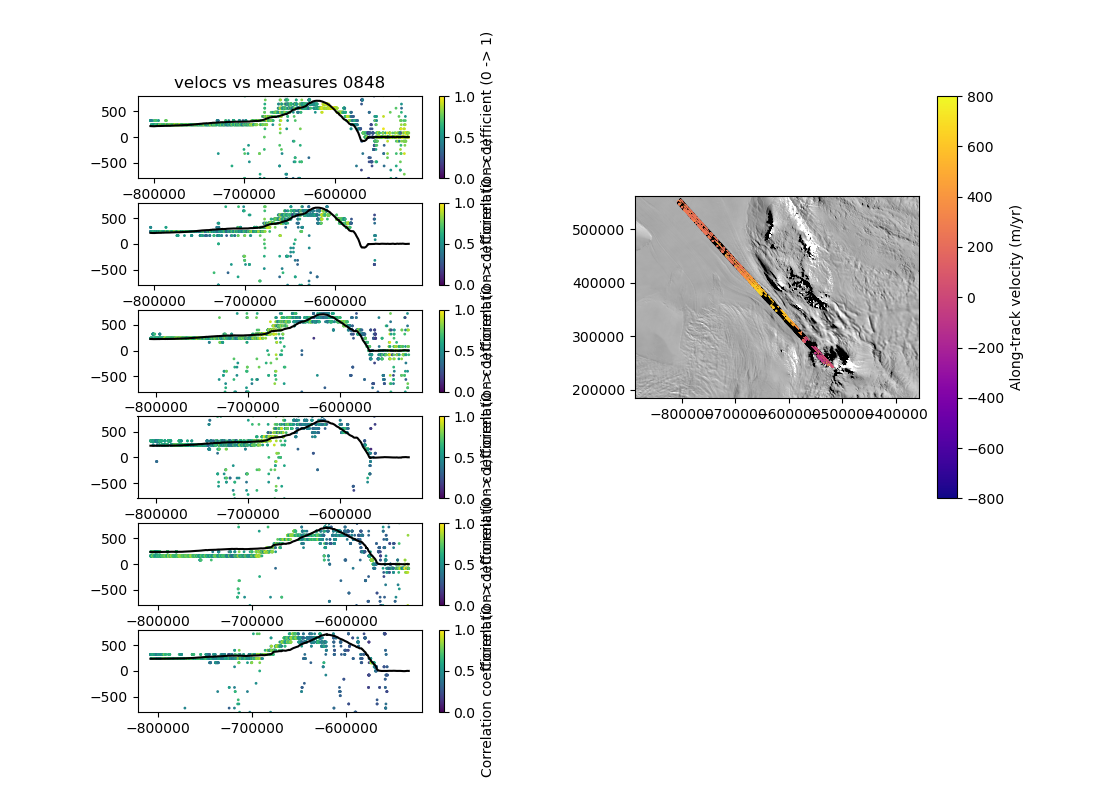

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-887950., -356950.,  183825.,  561825.]), 'origin': 'lower'}


In [9]:
from IS2_velocity.plotting import plot_measures_along_track_comparison

datapath = '/Users/grace/Dropbox/Cornell/projects/003/git_repo_old_Hackweek/surface_velocity/contributors/grace_barcheck/download/'
out_path = '/Users/grace/Dropbox/Cornell/projects/003/out_tmp/'
map_data_root = '/Users/grace/Dropbox/Cornell/projects/003/FIS_data/'
correlation_threshold = 0.65
plot_out_location = out_path
velocity_number = 0
spatial_extent = np.array([-65, -86, -55, -81])

plot_measures_along_track_comparison(rgt, beams, out_path, correlation_threshold, spatial_extent, plot_out_location, map_data_root, velocity_number)